In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import pickle
from tqdm import tqdm
from prince import FAMD


In [7]:
# us18_matches = pd.read_csv('tennis_data/2018-usopen-matches.csv')
# us18_matches = us18_matches.dropna(axis=1, how='all')

# us18_points = pd.read_csv('tennis_data/2018-usopen-points.csv')
# us18_points = us18_points.dropna(axis=1, how='all')
# matchups100 = pd.read_csv('matchups_atp100.csv')
rankings = pd.read_csv('Elo_Rankings2017.csv')

In [8]:
player_metadata = pd.read_csv('player_overviews_unindexed.csv')
player_metadata['name'] = [first + ' ' + last for first, last in zip(player_metadata.first_name, player_metadata.last_name)]
dropcol = ['player_url', 'flag_code', 'residence', 'birthplace', 'birthdate', 'birth_year', 'birth_month', 'birth_day', 'first_name', 'last_name']
player_metadata = player_metadata.drop(dropcol, axis='columns')
player_metadata = player_metadata[player_metadata['name'].isin(rankings.name.values[:101])]
player_metadata = player_metadata.reset_index()
player_metadata = player_metadata.dropna()
player_metadata.head()

,index,player_id,player_slug,turned_pro,weight_lbs,weight_kg,height_ft,height_inches,height_cm,handedness,backhand,name
0,137,a479,nicolas-almagro,2003.0,190.0,86.0,"6'0""",72.0,183.0,Right-Handed,One-Handed Backhand,Nicolas Almagro
1,175,a678,kevin-anderson,2007.0,205.0,93.0,"6'8""",80.0,203.0,Right-Handed,Two-Handed Backhand,Kevin Anderson
2,650,b747,julien-benneteau,2000.0,174.0,79.0,"6'1""",73.0,185.0,Right-Handed,Two-Handed Backhand,Julien Benneteau
3,668,b837,marcos-baghdatis,2003.0,181.0,82.0,"5'10""",70.0,178.0,Right-Handed,Two-Handed Backhand,Marcos Baghdatis
4,700,ba47,tomas-berdych,2002.0,200.0,91.0,"6'5""",77.0,196.0,Right-Handed,Two-Handed Backhand,Tomas Berdych


In [32]:
# Get all player names from a tourney

def get_player_names(matches):
    return np.unique(np.append(matches.player1.values, matches.player2.values))

# Given a player name and tourney, get their matches
def get_player_points(player, matches, points):
    # Get all match numbers
    match_ids = matches[(matches['player1'] == player) | (matches['player2'] == player)].match_id

    player_points = points[points.match_id.isin(match_ids)]

    return player_points


def get_summary_stats(player, matches, match):
    match_metadata = matches[matches.match_id == match.loc[1].match_id]
    # Get Ace percentage for that match
    if match_metadata.player1[0] == player:
        return match.P1Ace
    else:
        return match.P2Ace

def get_serves(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_serves = player_points[(player_points.match_id.isin(p1_matches)) & (player_points.ServeIndicator == 1)]  

    p2_matches = matches[matches['player2'] == player].match_id
    p2_serves = player_points[(player_points.match_id.isin(p2_matches)) & (player_points.ServeIndicator == 2)]

    player_serves = p1_serves.append(p2_serves)
    #player_serves.reset_index()

    return player_serves

# Function for getting points that were not made by double faulting (the ball was put into play)
def get_plays(player, matches, player_points):
    plays = player_points[(player_points.P1DoubleFault == 0) & (player_points.P2DoubleFault == 0)]
    return plays

def get_net_points(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_nets = player_points[(player_points.match_id.isin(p1_matches)) & (player_points.P1NetPoint == 1)]  

    p2_matches = matches[matches['player2'] == player].match_id
    p2_nets = player_points[(player_points.match_id.isin(p2_matches)) & (player_points.P2NetPoint == 1)]

    player_nets = p1_nets.append(p2_nets)

    return player_nets

def get_distances(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_dists = player_points[(player_points.match_id.isin(p1_matches))].P1DistanceRun 

    p2_matches = matches[matches['player2'] == player].match_id
    p2_dists = player_points[(player_points.match_id.isin(p2_matches))].P2DistanceRun

    return (np.sum(p1_dists) + np.sum(p2_dists))

def get_unforced_errors(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_unf_err = player_points[(player_points.match_id.isin(p1_matches))].P1UnfErr

    p2_matches = matches[matches['player2'] == player].match_id
    p2_unf_err = player_points[(player_points.match_id.isin(p2_matches))].P2UnfErr

    return (np.sum(p1_unf_err) + np.sum(p2_unf_err))


# Given a list of players, we want to go through the entire dataset and calculate a running average of their stats
Some assumptions made by this model are that players do not significantly change their playstlye throughout this calcualtion period 2011-2020.

In [33]:
players = rankings.name.values[:101]

colnames = ['nServes', 'Ace_Avg', 'SSpeed', 'nPlays', 'nNets', 'Net_Avg', 'Net_Win', 'Unf_Err']
player_stats = pd.DataFrame(0, index=players, columns=colnames)
player_stats.head()

#nadal_points = get_player_points('Rafael Nadal', us18_matches, us18_points)

tours = ['ausopen', 'frenchopen', 'usopen', 'wimbledon']


# Triple four loop dont tell my CS profs ;(
for year in tqdm(np.arange(2011, 2018)):
    for tour in tours:
        matches = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-matches.csv')
        points = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-points.csv')

        tour_players = list(set(np.append(matches.player1.values, matches.player2.values)))

        # Go through tournament players only in the top 100 (avoids NaN values)
        for player in [x for x in tour_players if x in players]:
            player_points = get_player_points(player, matches, points)

            update_row = []

            #-----------------------------------------------------------
            # Serve Stats
            #-----------------------------------------------------------
                # Calculate running average of Aces
            player_serves = get_serves(player, matches, points)

            ace_avg = (np.sum(player_serves.P1Ace) + np.sum(player_serves.P2Ace) + player_stats.loc[player].nServes * player_stats.loc[player].Ace_Avg) \
                / (np.shape(player_serves)[0] + player_stats.loc[player].nServes)
                
            update_row.append(np.shape(player_serves)[0] + player_stats.loc[player].nServes)
            update_row.append(ace_avg)

                # Calculate running average serve speed
            serve_speed_avg = (np.sum(player_serves.Speed_MPH) + player_stats.loc[player].nServes * player_stats.loc[player].SSpeed) \
                / (np.shape(player_serves)[0] + player_stats.loc[player].nServes)

            update_row.append(serve_speed_avg)

            #-----------------------------------------------------------
            # Net Stats
            #-----------------------------------------------------------
            player_plays = get_plays(player, matches, points)
            player_nets = get_net_points(player, matches, points)
                # Calculate running average of times player played the net
            avg_net_plays = (np.sum(player_nets.P1NetPoint) + np.sum(player_nets.P2NetPoint) + player_stats.loc[player].nPlays * player_stats.loc[player].Net_Avg) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            avg_net_wins = (np.sum(player_nets.P1NetPointWon) + np.sum(player_nets.P2NetPointWon) + player_stats.loc[player].nNets * player_stats.loc[player].Net_Win) \
                / (np.shape(player_nets)[0] + player_stats.loc[player].nNets)


            update_row.append(np.shape(player_plays)[0] + player_stats.loc[player].nPlays)
            update_row.append(np.shape(player_nets)[0] + player_stats.loc[player].nNets)
            update_row.append(avg_net_plays)
            update_row.append(avg_net_wins)

            #-----------------------------------------------------------
            # Gameplay Stats
            #-----------------------------------------------------------

                # Unforced error rate (consistency measure)
            player_errors = get_unforced_errors(player, matches, player_plays)
            avg_err = (player_errors + player_stats.loc[player].nPlays * player_stats.loc[player].Unf_Err) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)
            
            update_row.append(avg_err)


            player_stats.loc[player] = update_row


100%|██████████| 7/7 [00:49<00:00,  7.13s/it]


In [9]:
player_stats = pd.read_csv('player_stats.csv')
player_stats.index = player_stats['Unnamed: 0'].values
player_stats = player_stats.drop(['Unnamed: 0'], axis=1)
# Remove all zero players I could not get stats for
player_stats = player_stats.loc[~(player_stats==0).all(axis=1)]
# Remove players I don't have metadata for, not too bad I just lose like 4 from the top 100
player_stats = player_stats[player_stats.index.isin(player_metadata.name)]

player_metadata = player_metadata.set_index('name').loc[player_stats.index].reset_index()

player_stats['weight_kg'] = player_metadata.weight_kg.values
player_stats['height_cm'] = player_metadata.height_cm.values
player_stats['handedness'] = player_metadata.handedness.values
player_stats['backhand'] = player_metadata.backhand.values


con_feats = ['Ace_Avg', 'SSpeed', 'Net_Avg', 'Net_Win', 'Unf_Err', 'weight_kg', 'height_cm']

player_stats_con_feats = player_stats[con_feats]

player_stats.head()


,nServes,Ace_Avg,SSpeed,nPlays,nNets,Net_Avg,Net_Win,Unf_Err,weight_kg,height_cm,handedness,backhand
Roger Federer,13235.0,0.098300,104.448886,815673.0,4030.0,0.005115,0.733002,0.004400,85.0,185.0,Right-Handed,One-Handed Backhand
Novak Djokovic,15930.0,0.071689,103.212492,888535.0,3350.0,0.003897,0.729552,0.004787,77.0,188.0,Right-Handed,Two-Handed Backhand
Andy Murray,15843.0,0.076942,98.792211,856429.0,2829.0,0.003464,0.757511,0.004480,84.0,191.0,Right-Handed,Two-Handed Backhand
Rafael Nadal,11332.0,0.051535,100.886693,797522.0,1765.0,0.002320,0.816431,0.003085,85.0,185.0,Left-Handed,Two-Handed Backhand
Stan Wawrinka,7464.0,0.084539,101.048499,523136.0,1451.0,0.002774,0.707099,0.004498,81.0,183.0,Right-Handed,One-Handed Backhand


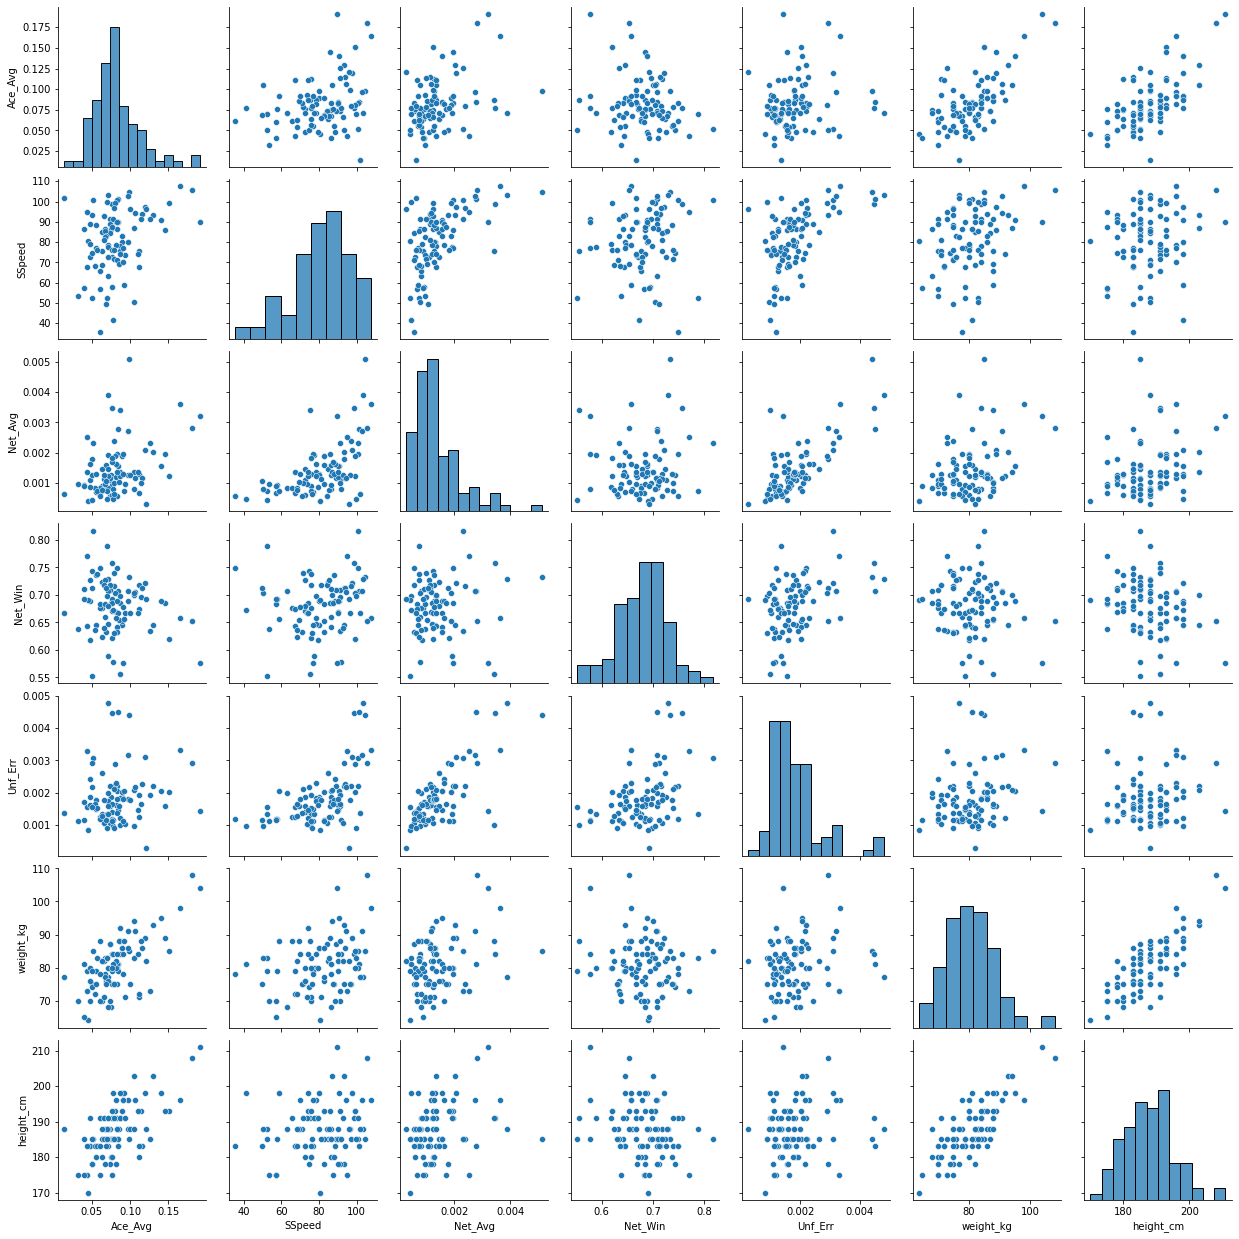

In [10]:
sns.pairplot(player_stats_con_feats)

# Clustering

Looks like five is a plausible choice so lets go with that:

# FAMD + Kmeans

In [47]:
con_feats = ['Ace_Avg', 'SSpeed', 'Net_Avg', 'Net_Win', 'Unf_Err']#, 'weight_kg', 'height_cm']
cat_feats = ['handedness', 'backhand']

famd = FAMD(
    n_components=4,
    engine='auto',
    random_state=98
)

X = player_stats[(con_feats + cat_feats)]
#X[con_feats] = scaler.fit_transform(X[con_feats])

famd = famd.fit(X)
print('Explained Inertias: ', famd.explained_inertia_)
print('Total inertia explained: ', np.sum(famd.explained_inertia_))

famd.row_coordinates(X).head()

Explained Inertias:  [0.29789309 0.23200163 0.20638577 0.13370663]
Total inertia explained:  0.8699871257762575


,0,1,2,3
Roger Federer,3.470733,0.749302,1.560441,-0.368810
Novak Djokovic,2.109512,-1.193266,1.592024,-1.010616
Andy Murray,1.895223,-1.117198,1.373122,-1.200718
Rafael Nadal,-0.193040,0.185754,2.533800,-1.957541
Stan Wawrinka,2.622268,0.851396,0.736524,-0.509280


# Analyze FAMD Fit

No handles with labels found to put in legend.


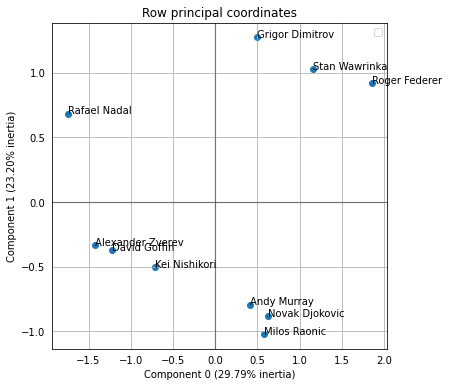

In [48]:
ax = famd.plot_row_coordinates(
     X[:10],
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     labels=X.index,
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
 )

In [49]:
famd.column_correlations(X)

,0,1,2,3
Ace_Avg,0.324682,-0.324346,0.322646,0.350604
Net_Avg,0.548910,-0.536928,0.547148,0.552875
Net_Win,0.132982,-0.125112,0.129492,0.088103
SSpeed,0.999802,-0.998109,0.999709,0.998832
Unf_Err,0.546447,-0.544339,0.540944,0.530706
backhand_One-Handed Backhand,0.035173,0.033589,0.014864,0.030788
backhand_Two-Handed Backhand,-0.035173,-0.033589,-0.014864,-0.030788
handedness_Left-Handed,-0.151581,0.159120,-0.113135,-0.140580
handedness_Right-Handed,0.151581,-0.159120,0.113135,0.140580


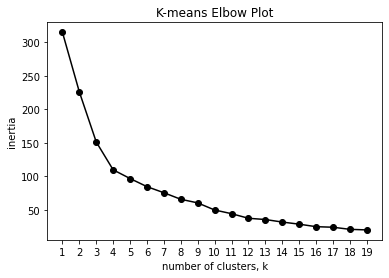

In [50]:
K = range(1,20)
inertias = []

for k in K:
    km = KMeans(
        init='random',
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=98
    )

    km = km.fit(famd.row_coordinates(X))
    inertias.append(km.inertia_)

plt.plot(K, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(K)
plt.title('K-means Elbow Plot')
plt.savefig('figures/elbow_plt.png')
plt.show()


In [52]:
km = KMeans(
    init='random',
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=98
)

play_class = km.fit(famd.row_coordinates(X))

# Save model to be used in gen_data script
pickle.dump(play_class, open('play_class_model.sav', 'wb'))

classes_df = pd.DataFrame({'Player': player_stats.index,
                           'Class': play_class.labels_})

classes_df.to_csv('player_classifications.csv', index=False)
classes_df.head(10)

,Player,Class
0,Roger Federer,3
1,Novak Djokovic,3
2,Andy Murray,3
3,Rafael Nadal,0
4,Stan Wawrinka,3
5,Grigor Dimitrov,2
6,Kei Nishikori,1
7,Milos Raonic,3
8,David Goffin,1
9,Alexander Zverev,1


# Sanity check the classifications

In [62]:
players_class0 = classes_df[classes_df.Class == 0].Player.values
players_class1 = classes_df[classes_df.Class == 1].Player.values
players_class2 = classes_df[classes_df.Class == 2].Player.values
players_class3 = classes_df[classes_df.Class == 3].Player.values

player_stats0 = player_stats.loc[players_class0][(con_feats + cat_feats)]
player_stats1 = player_stats.loc[players_class1][(con_feats + cat_feats)]
player_stats2 = player_stats.loc[players_class2][(con_feats + cat_feats)]
player_stats3 = player_stats.loc[players_class3][(con_feats + cat_feats)]

In [70]:
player_stats3

,Ace_Avg,SSpeed,Net_Avg,Net_Win,Unf_Err,handedness,backhand
Roger Federer,0.098300,104.448886,0.005115,0.733002,0.004400,Right-Handed,One-Handed Backhand
Novak Djokovic,0.071689,103.212492,0.003897,0.729552,0.004787,Right-Handed,Two-Handed Backhand
Andy Murray,0.076942,98.792211,0.003464,0.757511,0.004480,Right-Handed,Two-Handed Backhand
Stan Wawrinka,0.084539,101.048499,0.002774,0.707099,0.004498,Right-Handed,One-Handed Backhand
Milos Raonic,0.164636,107.436119,0.003623,0.657472,0.003335,Right-Handed,Two-Handed Backhand
Marin Cilic,0.119663,97.392804,0.002078,0.721564,0.003094,Right-Handed,Two-Handed Backhand
Tomas Berdych,0.096960,102.878136,0.002725,0.706983,0.003183,Right-Handed,Two-Handed Backhand
Gael Monfils,0.080895,99.084160,0.001882,0.703273,0.002881,Right-Handed,Two-Handed Backhand
John Isner,0.180263,105.664433,0.002807,0.653311,0.002927,Right-Handed,Two-Handed Backhand
David Ferrer,0.043288,94.752968,0.002520,0.770171,0.003308,Right-Handed,Two-Handed Backhand


In [65]:
print(players_class0)
print(player_stats0.mean())

print(players_class1)
print(player_stats1.mean())

print(players_class2)
print(player_stats2.mean())


print(players_class3)
print(player_stats3.mean())

['Rafael Nadal' 'Gilles Muller' 'Adrian Mannarino' 'Feliciano Lopez'
 'Fernando Verdasco' 'Mischa Zverev' 'Donald Young' 'Federico Delbonis'
 'Jiri Vesely' 'Guido Pella' 'Yoshihito Nishioka' 'Denis Shapovalov'
 'Horacio Zeballos' 'Martin Klizan' 'Ruben Bemelmans' 'Thomaz Bellucci']
Ace_Avg     0.075688
SSpeed     76.677725
Net_Avg     0.001329
Net_Win     0.675240
Unf_Err     0.001466
dtype: float64
['Kei Nishikori' 'David Goffin' 'Alexander Zverev' 'Nick Kyrgios'
 'Roberto Bautista Agut' 'Jack Sock' 'Kevin Anderson' 'Lucas Pouille'
 'Fabio Fognini' 'Sam Querrey' 'Damir Dzumhur' 'Pablo Carreno Busta'
 'Alexandr Dolgopolov' 'Steve Johnson' 'Hyeon Chung' 'Marcos Baghdatis'
 'Kyle Edmund' 'Julien Benneteau' 'Viktor Troicki' 'Borna Coric'
 'Andrey Rublev' 'Radek Stepanek' 'Juan Monaco' 'Gilles Simon'
 'Robin Haase' 'Ryan Harrison' 'Yuichi Sugita' 'Andreas Seppi'
 'Jared Donaldson' 'Andrey Kuznetsov' 'Florian Mayer' 'Jerzy Janowicz'
 'Denis Istomin' 'Karen Khachanov' 'Peter Gojowczyk' 'Beno

# Player Classification Naming

- 0: Characterized by consistency, low unforced error rates and left-handedness, no distinct backhand

- 1: Distinctly right handed - two handed backhanders, not good at net points, also more consistent

- 2: Distinctly One-handed backhanders. Second highest serve speed group.

- 3: Characterized by killer serves and high net play